<a href="https://colab.research.google.com/github/sahil-37/Customer_Segmentation/blob/main/Customer_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yellowbrick pyod shap prince sentence_transformers


In [2]:
!pip freeze > requirements.txt

In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.7 MB/s eta 0:00:00
Processing /colabtools/dist/google-colab-1.0.0.tar.gz (from -r requirements.txt (line 143))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [3]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

In [4]:
!gdown 1AiP4h4dwAXb5f0oF0K6lJBfZtFmyAs0J
!gdown 1FCYFZ3dNvOsW03iJ2dM8KGcIe3WYdI5L

Downloading...
From: https://drive.google.com/uc?id=1AiP4h4dwAXb5f0oF0K6lJBfZtFmyAs0J
To: /content/train.csv
100% 4.61M/4.61M [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FCYFZ3dNvOsW03iJ2dM8KGcIe3WYdI5L
To: /content/test.csv
100% 461k/461k [00:00<00:00, 105MB/s]


In [5]:
df = pd.read_csv("/content/train.csv", sep = ";")
df = df.iloc[:, 0:8]

In [6]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_transformer_onehot = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
    ])

categorical_transformer_ordinal = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ])

num = Pipeline(
    steps=[
        ("encoder", PowerTransformer())
    ])


preprocessor  = ColumnTransformer(transformers = [
                                        ('cat_onehot', categorical_transformer_onehot, ["default", "housing", "loan", "job", "marital"]),
                                        ('cat_ordinal', categorical_transformer_ordinal, ["education"]),
                                        ('num', num, ["age", "balance"])
                                        ])

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor)]
    )
pipe_fit = pipeline.fit(df)

data = pd.DataFrame(pipe_fit.transform(df), columns = pipe_fit.get_feature_names_out().tolist())


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
def remove_outliers(data,df):
    # Initialize and fit the ECOD model
    clf = ECOD()
    clf.fit(data)

    # Predict outliers
    outliers = clf.predict(data)

    # Add outlier predictions to the data
    data["outliers"] = outliers
    df["outliers"] = outliers

    # Filter data without outliers
    data_no_outliers = data[data["outliers"] == 0].drop(["outliers"], axis=1)
    df_no_outliers = df[df["outliers"] == 0].drop(["outliers"], axis=1)
    # Return data without outliers and original data without outliers
    return data_no_outliers, df_no_outliers

In [8]:
data_no_outliers, df_no_outliers = remove_outliers(data,df)


In [9]:
df_no_outliers.head()

age           job  marital  education default  balance housing loan
0   58    management  married   tertiary      no     2143     yes   no
1   44    technician   single  secondary      no       29     yes   no
2   33  entrepreneur  married  secondary      no        2     yes  yes
3   47   blue-collar  married    unknown      no     1506     yes   no
5   35    management  married   tertiary      no      231     yes   no

In [10]:
print(data_no_outliers.shape)
print(df_no_outliers.shape)

(40690, 19)
(40690, 8)


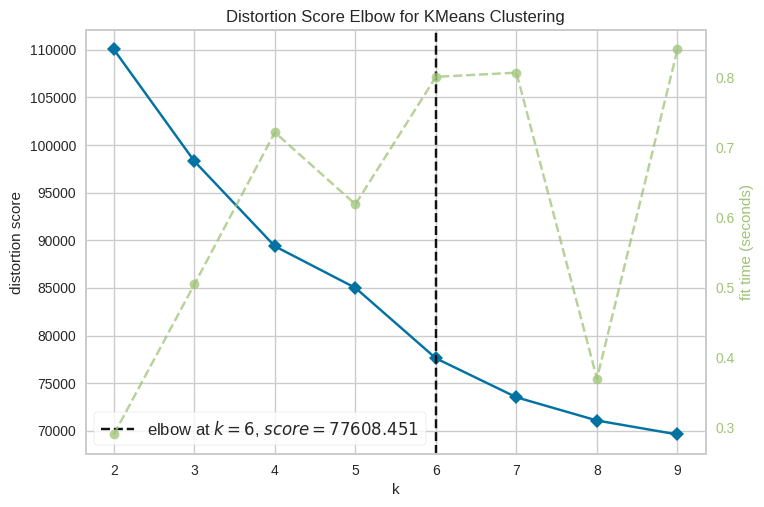

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(data_no_outliers)        # Fit the data to the visualizer
visualizer.show()

In [91]:
from sklearn.cluster import KMeans

def kmeans_clustering(df_embedding, n_clusters):
    # Initialize KMeans clustering model
    clusters = KMeans(n_clusters=n_clusters, init="k-means++").fit(df_embedding)

    # Get inertia
    inertia = clusters.inertia_

    # Predict clusters for the data
    clusters_predict = clusters.predict(df_embedding)

    return clusters_predict, inertia

clusters_predict, inertia = kmeans_clustering(data_no_outliers, 5)
print("Inertia:", inertia)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia: 81380.74796918192


In [13]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(data_no_outliers,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters_predict)}")

Davies bouldin score: 1.6767304008118344
Calinski Score: 6914.690453536672
Silhouette Score: 0.16728216897558568


In [ ]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df,
                        x=columns[0],
                        y=columns[1],
                        z=columns[2],
                        color='cluster',
                        template="plotly",

                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000,
                                height = 800,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df,
                        x=columns[0],
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()

In [ ]:
pca_3d_object, df_pca_3d = get_pca_3d(data_no_outliers, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.245        11.81%                     11.81%
1              1.774         9.34%                     21.15%
2              1.298         6.83%                     27.98%


In [ ]:
pca_2d_object, df_pca_2d = get_pca_2d(data_no_outliers, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.5)

In [ ]:
sampling_data = data_no_outliers.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3,
                  learning_rate=700,
                  init='random',
                  perplexity=100,
                  n_iter = 1000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

KeyboardInterrupt: 

In [ ]:
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=0.3, width_line = 0.1)


In [ ]:
df_tsne_2d = TSNE(
                  n_components=2,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)

In [15]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

In [78]:
def train_lightgbm_and_shap(df, target,category):
    # Initialize LightGBM classifier
    clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

    # Convert categorical columns to 'category' data type
    for col in category:
        df[col] = df[col].astype('category')

    # Train the LightGBM classifier
    clf_km.fit(X=df, y=target, feature_name="auto", categorical_feature=categorical_features)

    # Generate SHAP values
    explainer_km = shap.TreeExplainer(clf_km)
    shap_values_km = explainer_km.shap_values(df)

    return clf_km, shap_values_km



In [102]:
clf_km, shap_values_km = train_lightgbm_and_shap(df_no_outliers, clusters_predict, categorical_features)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 9
[LightGBM] [Info] Start training from score -1.292930
[LightGBM] [Info] Start training from score -1.412943
[LightGBM] [Info] Start training from score -2.815215
[LightGBM] [Info] Start training from score -1.626166
[LightGBM] [Info] Start training from score -1.489282


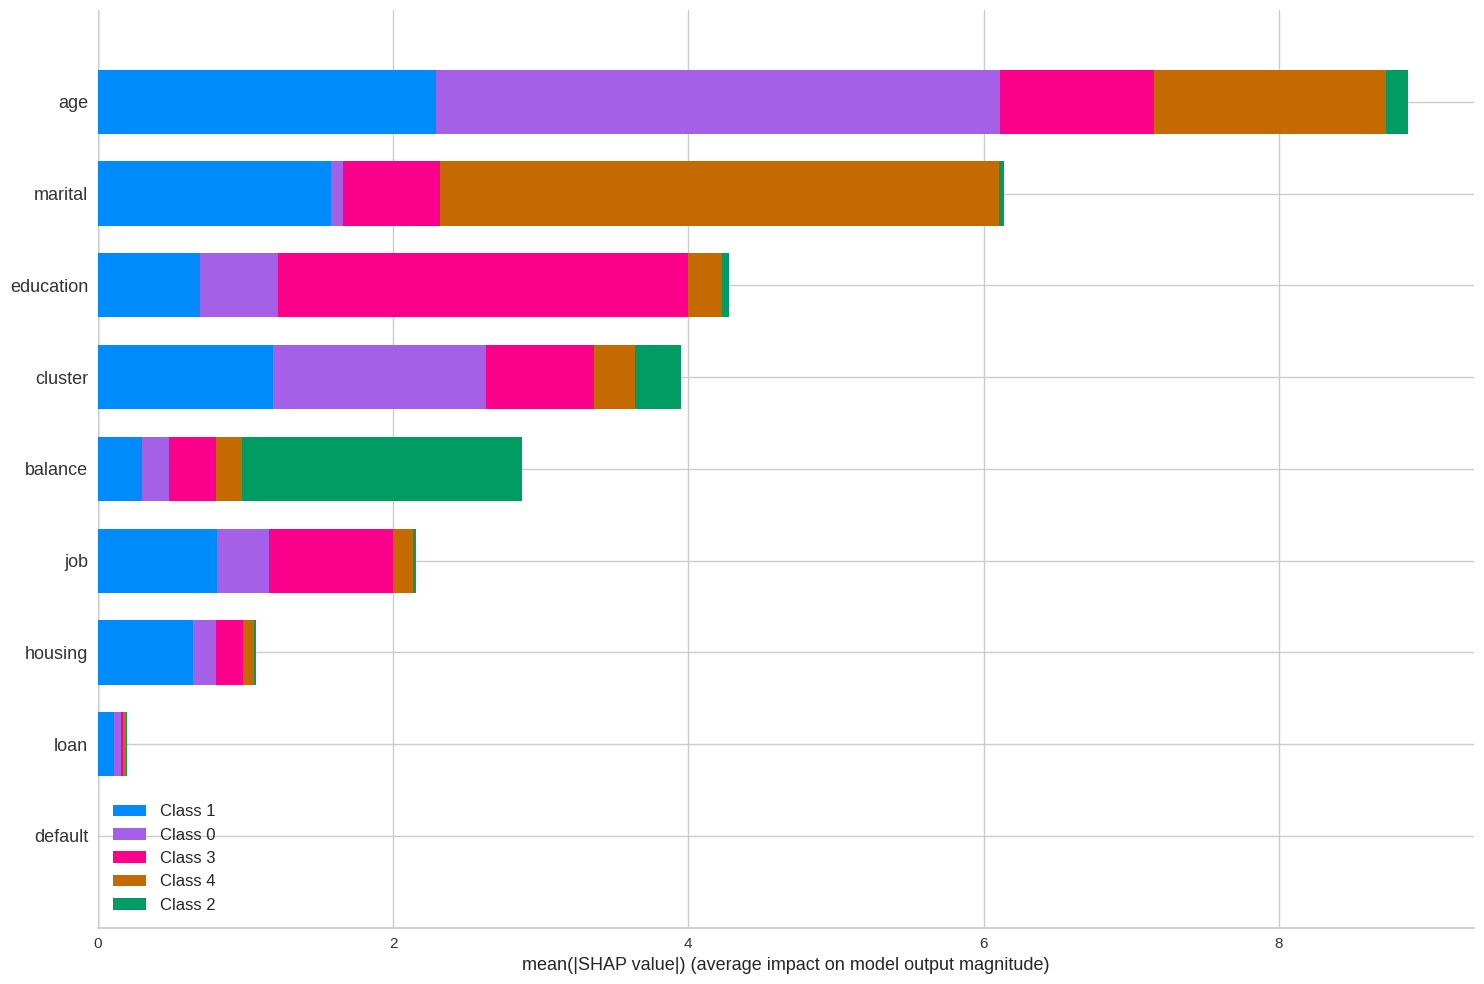

In [103]:
shap.summary_plot([shap_values_km[:, :, class_ind] for class_ind in range(shap_values_km.shape[-1])], df_no_outliers, plot_type="bar", plot_size=(15, 10))


In [66]:
def group_and_aggregate(df, clusters_predict):
    # Add cluster predictions to the DataFrame
    df["cluster"] = clusters_predict

    # Define aggregation functions
    agg_funcs = {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age': 'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0]
    }

    # Group by cluster and aggregate
    df_group = df.groupby('cluster').agg(agg_funcs).sort_values("job").reset_index()

    return df_group

# Example usage:
df_group = group_and_aggregate(df_no_outliers, clusters_predict)


In [67]:

from sentence_transformers import SentenceTransformer



df_sen = pd.read_csv("/content/train.csv", sep = ";")

def compile_text(x):


    text =  f"""Age: {x['age']},
                housing load: {x['housing']},
                Job: {x['job']},
                Marital: {x['marital']},
                Education: {x['education']},
                Default: {x['default']},
                Balance: {x['balance']},
                Personal loan: {x['loan']}
            """

    return text

sentences = df_sen.apply(lambda x: compile_text(x), axis=1).tolist()



model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")

output = model.encode(sentences=sentences, show_progress_bar= True, normalize_embeddings  = True)

df_embedding = pd.DataFrame(output)
df_embedding


df_embedding.to_csv("embedding_train.csv",index = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/1413 [00:00<?, ?it/s]

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,
       ...
              375,        376,        377,        378,        379,        380,
              381,        382,        383, 'outliers'],
      dtype='object', length=385)

In [68]:
data_embedding_no_outliers, df_embedding_no_outliers = remove_outliers(df_embedding,df)


In [69]:
df_embedding_no_outliers

age          job   marital  education default  balance housing loan
0       58   management   married   tertiary      no     2143     yes   no
1       44   technician    single  secondary      no       29     yes   no
3       47  blue-collar   married    unknown      no     1506     yes   no
5       35   management   married   tertiary      no      231     yes   no
6       28   management    single   tertiary      no      447     yes  yes
...    ...          ...       ...        ...     ...      ...     ...  ...
45205   25   technician    single  secondary      no      505      no  yes
45206   51   technician   married   tertiary      no      825      no   no
45207   71      retired  divorced    primary      no     1729      no   no
45208   72      retired   married  secondary      no     5715      no   no
45209   57  blue-collar   married  secondary      no      668      no   no

[40690 rows x 8 columns]

In [99]:
emb_clusters_predict, emb_inertia = kmeans_clustering(data_embedding_no_outliers,5)
print("Inertia:", emb_inertia)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia: 1101.6162109375


In [100]:
clf_em, shap_values_em = train_lightgbm_and_shap(df=df_embedding_no_outliers, target=emb_clusters_predict, category=categorical_features)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 9
[LightGBM] [Info] Start training from score -1.844541
[LightGBM] [Info] Start training from score -1.071579
[LightGBM] [Info] Start training from score -1.528734
[LightGBM] [Info] Start training from score -2.324952
[LightGBM] [Info] Start training from score -1.688283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

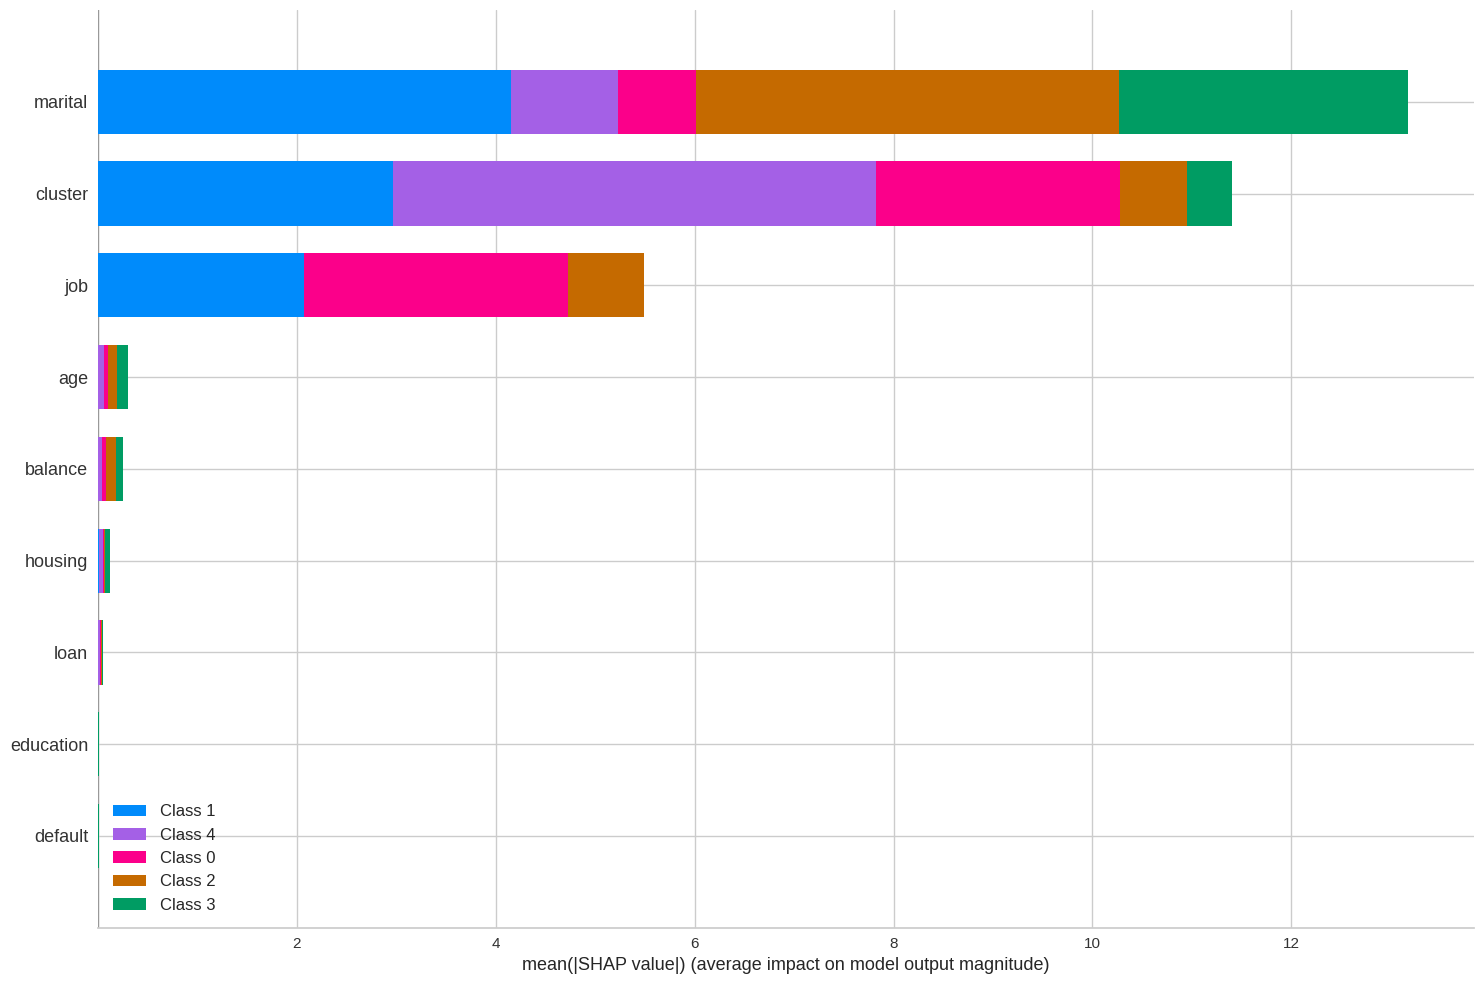

In [101]:
shap.summary_plot([shap_values_em[:, :, class_ind] for class_ind in range(shap_values_em.shape[-1])], df_embedding_no_outliers, plot_type="bar", plot_size=(15, 10))


In [97]:
shap_values_em.shape

(40690, 8, 5)

In [98]:
emb_df_group = group_and_aggregate(df_embedding_no_outliers, emb_clusters_predict)
emb_df_group

cluster          job  marital  education housing loan        age  \
0        2       admin.  married  secondary     yes   no  41.734979   
1        4  blue-collar  married  secondary     yes   no  40.108177   
2        0   management   single  secondary     yes   no  34.152765   
3        3   management  married   tertiary      no   no  45.662682   
4        1   technician  married  secondary     yes   no  42.212265   

       balance default  
0  1176.983641      no  
1  1056.395549      no  
2  1303.645206      no  
3  1631.129676      no  
4  1212.023126      no

from matplotlib import pyplot as plt
emb_df_group['cluster'].plot(kind='hist', bins=20, title='cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
emb_df_group['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
emb_df_group['balance'].plot(kind='hist', bins=20, title='balance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
emb_df_group.groupby('job').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
emb_df_group.groupby('marital').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
emb_df_group.groupby('education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
emb_df_group.groupby('housing').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


from matplotlib import pyplot as plt
emb_df_group.plot(kind='scatter', x='cluster', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


from matplotlib import pyplot as plt
emb_df_group.plot(kind='scatter', x='age', y='balance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
emb_df_group['cluster'].plot(kind='line', figsize=(8, 4), title='cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
emb_df_group['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
emb_df_group['balance'].plot(kind='line', figsize=(8, 4), title='balance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital'].value_counts()
    for x_label, grp in emb_df_group.groupby('job')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('job')
_ = plt.ylabel('marital')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in emb_df_group.groupby('marital')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital')
_ = plt.ylabel('education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['housing'].value_counts()
    for x_label, grp in emb_df_group.groupby('education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('education')
_ = plt.ylabel('housing')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(emb_df_group['job'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(emb_df_group, x='cluster', y='job', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(emb_df_group['marital'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(emb_df_group, x='cluster', y='marital', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(emb_df_group['education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(emb_df_group, x='cluster', y='education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(emb_df_group['housing'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(emb_df_group, x='cluster', y='housing', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)